In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import os
import cv2
import sys
import matplotlib.image as mpimg
from PIL import Image
import scipy
from scipy import ndimage
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

import pickle
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from configs import *
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
#First resize images into specific width and height
#Un comment below line in case you have remove me images and load your images into the same folder
# read_mixed_width_and_height_images() # save as 100 * 100 * 3 images


In [3]:
# read_mixed_width_and_height_images(300, "_300_300_3/") # save as 300 * 300 * 3 images

In [4]:
# read_mixed_width_and_height_images(500, "_500_500_3/") # save as 300 * 300 * 3 images

I have 351 image of me
I have 346 image of others
Now total number of images is 697
The shape of y is:  (1, 697)
===================Before===================
(600, 30000)
(97, 30000)
(1, 600)
(1, 97)
===================After===================
(30000, 600)
(30000, 97)
(1, 600)
(1, 97)


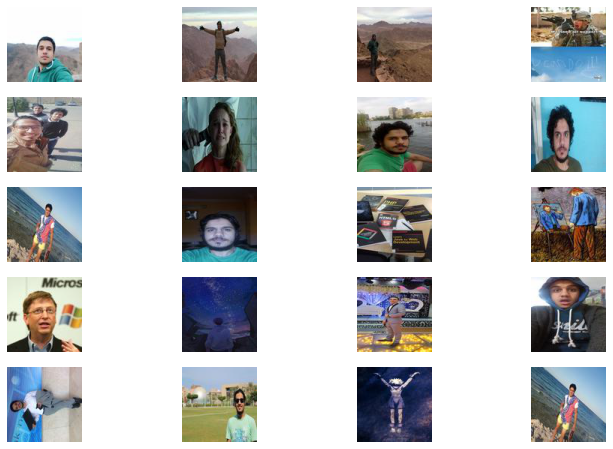

In [5]:
df_all_images = images_pipeline(100, "_100_100_3/")
X_train, X_val, y_train, y_val = load_train_validation_set(df_all_images)
display_some_images(X_train)

## Manual Logistic Regression 

This is run logistic regression from scratch.

In [6]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A

def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0.0
    return w, b

def propagate(w, b, X, Y):
    m, n = X.shape[1], X.shape[0] 
    Z = np.matmul(w.T, X) + b # Prediction
    A = sigmoid(Z)          # map prediction between 0 and 1
    cost = -(1/m) * (np.dot(Y, np.log(A).T) + np.dot((1-Y) , np.log(1-A).T))
    dZ = np.dot(X, (A-Y).T)
    dW = (1/m) * dZ
    dB = (1/m) * np.sum(dZ)
    grads = {"dW": dW,
             "dB": dB}
    return grads, cost

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        dW = grads['dW']
        dB = grads['dB']
        w = w - learning_rate * dW
        b = b - learning_rate * dB
        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    params = {"w": w,
              "b": b}

    grads = {"dW": dW,
             "dB": dB}
    return params, grads, costs


def predict(w, b, X):
    m, n = X.shape[0], X.shape[1] 
    Z = np.matmul(w.T, X) + b # Prediction
    A = sigmoid(Z)          # map prediction between 0 and 1
    Y_prediction = 1. * (A > 0.5)
    return Y_prediction


def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    
    w,b  =initialize_with_zeros(X_train.shape[0])
    
    parameters, grads, costs = optimize(w, b, X_train, Y_train,
                                        num_iterations, learning_rate, print_cost=False)
    w = parameters["w"]
    b = parameters["b"]

    Y_prediction_test  = predict(w,b,X_val)
    Y_prediction_train = predict(w,b,X_train)
    

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

d = model(X_train, y_train, X_val, y_val, num_iterations = 1000, learning_rate = 0.5, print_cost = True)

train accuracy: 58.33333333333333 %
test accuracy: 53.608247422680414 %


[1]


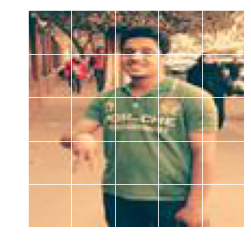

In [7]:
# Example of a picture that was wrongly classified.
index = 2
print(y_val[:,index])
plt.imshow(X_val[:,index].reshape((100, 100, 3)))

In [8]:
X_val[:,index].shape

(30000,)

In [9]:

my_predicted_image = predict(d["w"], d["b"], X_val[:,index].reshape(-1, 1))

print(my_predicted_image)

[[1.]]


[1]


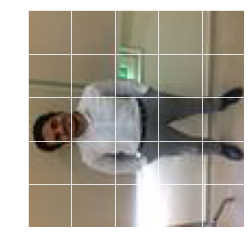

In [10]:
# Example of a picture that was wrongly classified.

index = 9
print(y_val[:,index])
plt.imshow(X_val[:,index].reshape((100, 100, 3)))


In [11]:

my_predicted_image = predict(d["w"], d["b"], X_val[:,index].reshape(-1, 1))

print(my_predicted_image)

[[1.]]


## Train Logstic Model Using Sklearn

In [12]:
X_train, X_val,y_train, y_val = X_train.T, X_val.T, y_train.T, y_val.T

In [13]:
def fit_predict_print_f1_score(model, model_name, X_train=X_train, y_train=y_train):
    
    model.fit(X_train, y_train)  
    predicted              = model.predict(X_train)
    f1_scr                 = f1_score(y_train, predicted)
    print("f1 score on traning with classifer: " + model_name + str(f1_scr))
    print("="*50)
    return model

In [14]:
def grid_search_logistic_regression_ridge_l2_norm(parameters, X_train=X_train, y_train=y_train):
    '''
    The function used to search for best parameter that we can use with Ridge Regression L2,
    to used later for LogisticRegression model with L2 regularization only,
    and related hyper paramter can be used with Ridge Regression L2.
    '''
    
     # First search for best parameter
    log_reg_clf                            = LogisticRegression(penalty="l2", n_jobs=-1)
    grd_serch                              = GridSearchCV(log_reg_clf, parameters, cv=2)
    grd_serch.fit(X_train, y_train)
    
    print("Score: ====================")
    print(grd_serch.best_score_)
    
    print("Best Params: ====================")
    print(grd_serch.best_params_)
    print("="*50)
    
    # return the best best parameter of the Ridge Regression L2
    solver_                                = grd_serch.best_params_['solver']
    max_iter_                              = grd_serch.best_params_['max_iter']
#     tol_                                   = grd_serch.best_params_['tol']
    
    # Create instance of Ridge Regression L2 with best parameter we have found
    trained_logistic_reg_ridge_l2_norm_clf = LogisticRegression(penalty="l2", solver=solver_,
                                                          max_iter=max_iter_, n_jobs=-1)
    
    return trained_logistic_reg_ridge_l2_norm_clf

In [15]:
def train_logistic_classifier(parameters, X_train=X_train, y_train=y_train):
    '''
    The function used to train different logistic classifier based on the Regularization Term (norm_type)
    '''
    
    # For Ridge Regression
    # Search for best parameters with L2 Regression and return LogisticRegression object with these best param
    trained_logistic_reg_ridge_l2_norm_clf = grid_search_logistic_regression_ridge_l2_norm(parameters)

    # The function used to fit any model send to it, then get f1_score and print using this trained model
    trained_logistic_reg_ridge_l2_norm_clf = fit_predict_print_f1_score(trained_logistic_reg_ridge_l2_norm_clf, 
                                                              "Ridge Regression L2 Norm classifier: ")
        
    return trained_logistic_reg_ridge_l2_norm_clf
    


In [16]:
# # Paramter for logistic regression l2 norm
# logistic_reg_ridge_l2_norm_parameters     = {'solver': ["lbfgs", "liblinear", "saga"],
#                                              'max_iter': list(np.linspace(1000, 2000, 3).astype(int)), 
#                                              }

# # Logistic Regression Classifier Ridge L2 Norm
# trained_logistic_reg_ridge_l2_norm_clf    = train_logistic_classifier(logistic_reg_ridge_l2_norm_parameters)


In [17]:
# # Validate 
# predicted              = trained_logistic_reg_ridge_l2_norm_clf.predict(X_val)
# f1_scr                 = f1_score(y_val, predicted)
# print("f1 score on validation with classifer: " + str(f1_scr))

## Let's see this accurate prediction

In [18]:
# # X.shape[0] to get number of images we have, then take size of 20 image
# images = X_val[:10]
# print(images.shape)
# print(images[0].shape)
# labels = y_val[:10]
# predict = trained_logistic_reg_ridge_l2_norm_clf.predict(images).reshape(-1, 1)
# print(labels.reshape(-1))
# print(predict.reshape(-1))
# print((labels == predict).reshape(-1))

# # Class 1 means me class 0 means other lets display these 10 images

In [19]:
# trained_logistic_reg_ridge_l2_norm_clf.predict(im)

In [20]:
# # Reshape
# random_images_rows = images.reshape(10, 100, 100, 3)

# # Display the images
# fig, axes = plt.subplots(2,5, figsize=(10,4))

# for i,ax in enumerate(axes.flat):
#     ax.imshow(random_images_rows[i])
#     ax.axis("off")

In [21]:
# # Save logistic Model
# filename = 'trained_logistic_reg_ridge_l2_norm_clf_100_100_3_image_shape.sav'
# pickle.dump(trained_logistic_reg_ridge_l2_norm_clf, open("saved_model_weights/" + filename, 'wb'))

In [ ]:
df_all_images = images_pipeline(300, "_300_300_3/")
X_train, X_val, y_train, y_val = load_train_validation_set(df_all_images)
# display_some_images(X_train, 300)

In [ ]:
X_train.shape

In [ ]:
# Paramter for logistic regression l2 norm
logistic_reg_ridge_l2_norm_parameters     = {'solver': ["lbfgs", "liblinear", "saga"],
                                             'max_iter': list(np.linspace(1000, 2000, 3).astype(int)), 
                                             }

# Logistic Regression Classifier Ridge L2 Norm
trained_logistic_reg_ridge_l2_norm_clf    = train_logistic_classifier(logistic_reg_ridge_l2_norm_parameters,
                                                                     X_train, y_train)

# Validate 
predicted              = trained_logistic_reg_ridge_l2_norm_clf.predict(X_val)
f1_scr                 = f1_score(y_val, predicted)
print("f1 score on validation with classifer: " + str(f1_scr))

In [ ]:
# Reshape
random_images_rows = images.reshape(10, 100, 100, 3)

# Display the images
fig, axes = plt.subplots(2,5, figsize=(10,4))

for i,ax in enumerate(axes.flat):
    ax.imshow(random_images_rows[i])
    ax.axis("off")

In [ ]:
# Save logistic Model
filename = 'trained_logistic_reg_ridge_l2_norm_clf_300_300_3_image_shape.sav'
pickle.dump(trained_logistic_reg_ridge_l2_norm_clf, open("saved_model_weights/" + filename, 'wb'))

In [ ]:
df_all_images = images_pipeline(500, "_500_500_3/")
X_train, X_val, y_train, y_val = load_train_validation_set(df_all_images)
display_some_images(X_train)


In [ ]:
# Paramter for logistic regression l2 norm
logistic_reg_ridge_l2_norm_parameters     = {'solver': ["lbfgs", "liblinear", "saga"],
                                             'max_iter': list(np.linspace(1000, 2000, 3).astype(int)), 
                                             }

# Logistic Regression Classifier Ridge L2 Norm
trained_logistic_reg_ridge_l2_norm_clf    = train_logistic_classifier(logistic_reg_ridge_l2_norm_parameters,
                                                                     X_train, y_train)

# Validate 
predicted              = trained_logistic_reg_ridge_l2_norm_clf.predict(X_val)
f1_scr                 = f1_score(y_val, predicted)
print("f1 score on validation with classifer: " + str(f1_scr))

In [ ]:
# Reshape
random_images_rows = images.reshape(10, 100, 100, 3)

# Display the images
fig, axes = plt.subplots(2,5, figsize=(10,4))

for i,ax in enumerate(axes.flat):
    ax.imshow(random_images_rows[i])
    ax.axis("off")

In [ ]:
# Save logistic Model
filename = 'trained_logistic_reg_ridge_l2_norm_clf_500_500_3_image_shape.sav'
pickle.dump(trained_logistic_reg_ridge_l2_norm_clf, open("saved_model_weights/" + filename, 'wb'))